In [1]:
# 最终画图选的参数：
# DG 10 2 6
# EG 10 2 3
# zebrafish 20 2 3

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
import scvelo as scv
from torch.optim import SGD, Adam, Adagrad
from function import *

from utils import *
from g2g_model_Fisher import *


In [ ]:
data_path = f'data/'
path_path = "RC_path/"
figure_path="figure/velocity/"
cmap = plt.colormaps['Spectral_r']
save = True

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'celltype', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_point

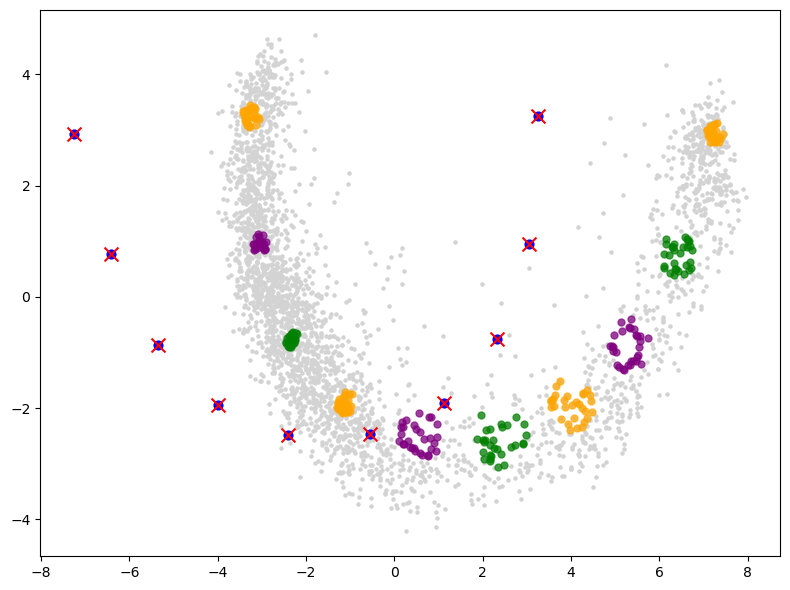

用的color_dict是： {'Granule': '#1f77b4', 'ImmGranule1': '#ff7f0e', 'ImmGranule2': '#2ca02c', 'Nbl1': '#d62728', 'Nbl2': '#9467bd', 'RadialGlia': '#8c564b', 'nIPC': '#e377c2'}
用的celltype_colors是： ['#8c564b', '#ff7f0e', '#ff7f0e', '#1f77b4', '#2ca02c', '#d62728', '#ff7f0e', '#9467bd', '#2ca02c', '#1f77b4', '#1f77b4', '#1f77b4', '#2ca02c', '#1f77b4', '#1f77b4', '#2ca02c', '#ff7f0e', '#1f77b4', '#e377c2', '#1f77b4', '#e377c2', '#ff7f0e', '#e377c2', '#1f77b4', '#1f77b4', '#e377c2', '#d62728', '#2ca02c', '#9467bd', '#e377c2', '#2ca02c', '#9467bd', '#ff7f0e', '#1f77b4', '#8c564b', '#2ca02c', '#e377c2', '#9467bd', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e', '#2ca02c', '#e377c2', '#d62728', '#9467bd', '#2ca02c', '#d62728', '#2ca02c', '#2ca02c', '#e377c2', '#ff7f0e', '#e377c2', '#9467bd', '#2ca02c', '#2ca02c', '#2ca02c', '#ff7f0e', '#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#ff7f0e', '#1f77b4', '#2ca02c', '#9467bd', '#e377c2', '#d62728', '#8c564b', '#2ca02c', '#94

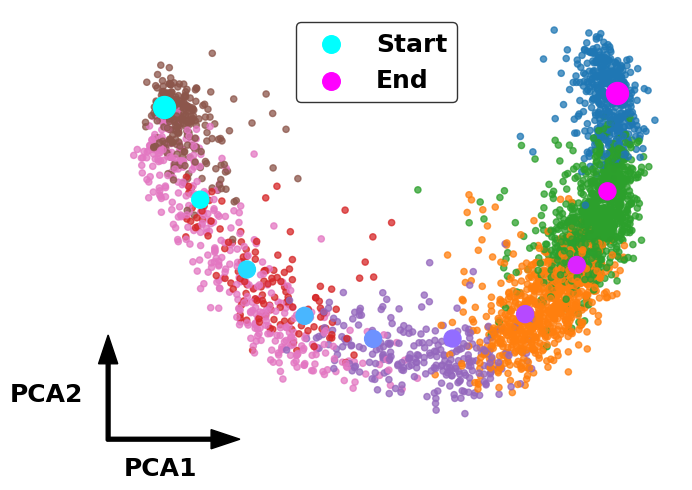

(3139,)
(3139,)
(30,)
(30,)


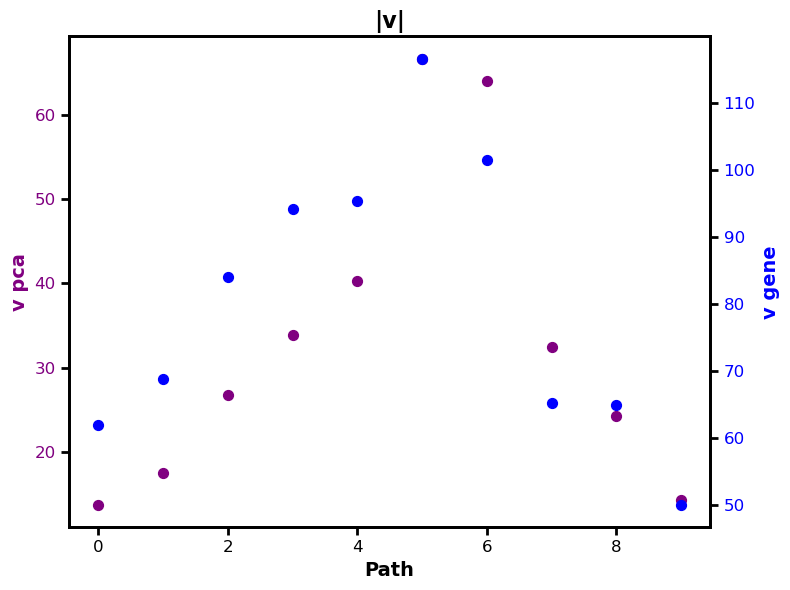

现在是直接用.autograd()求导的：


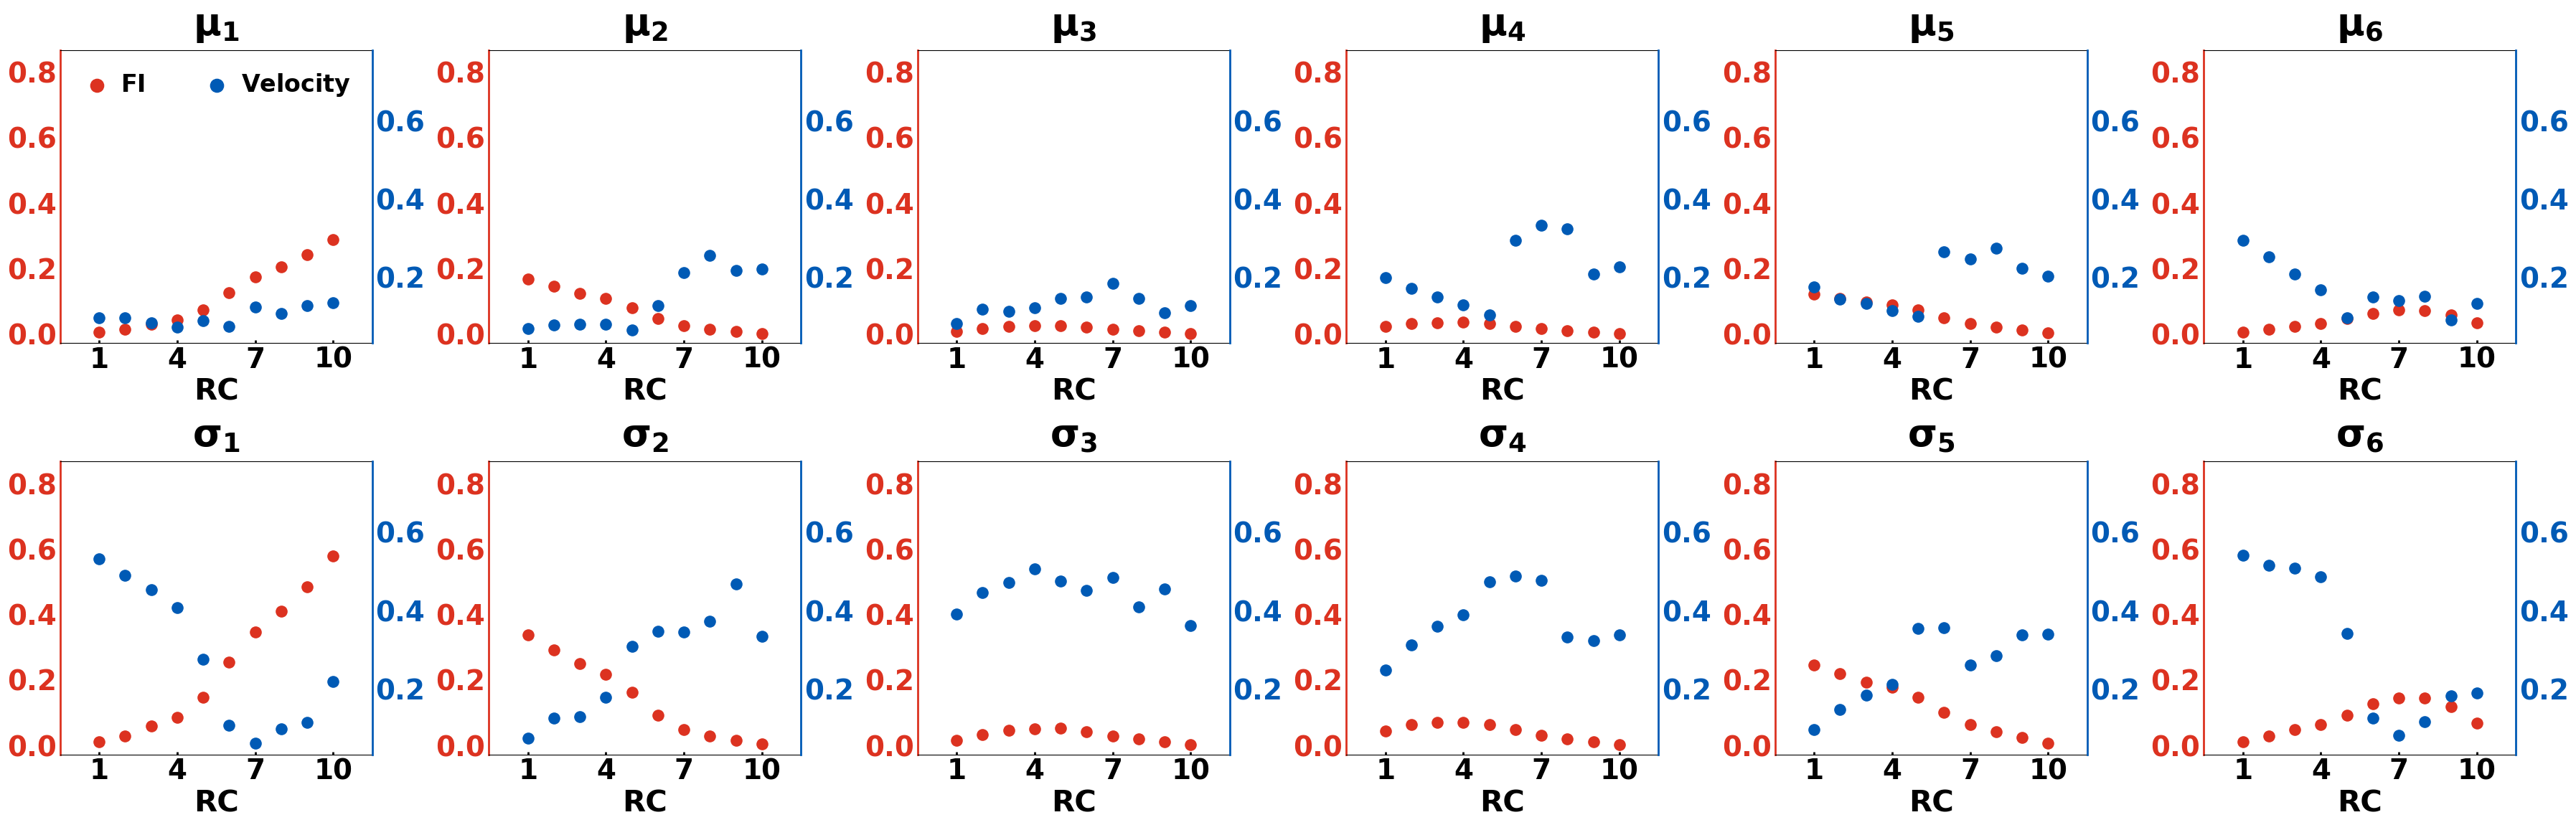

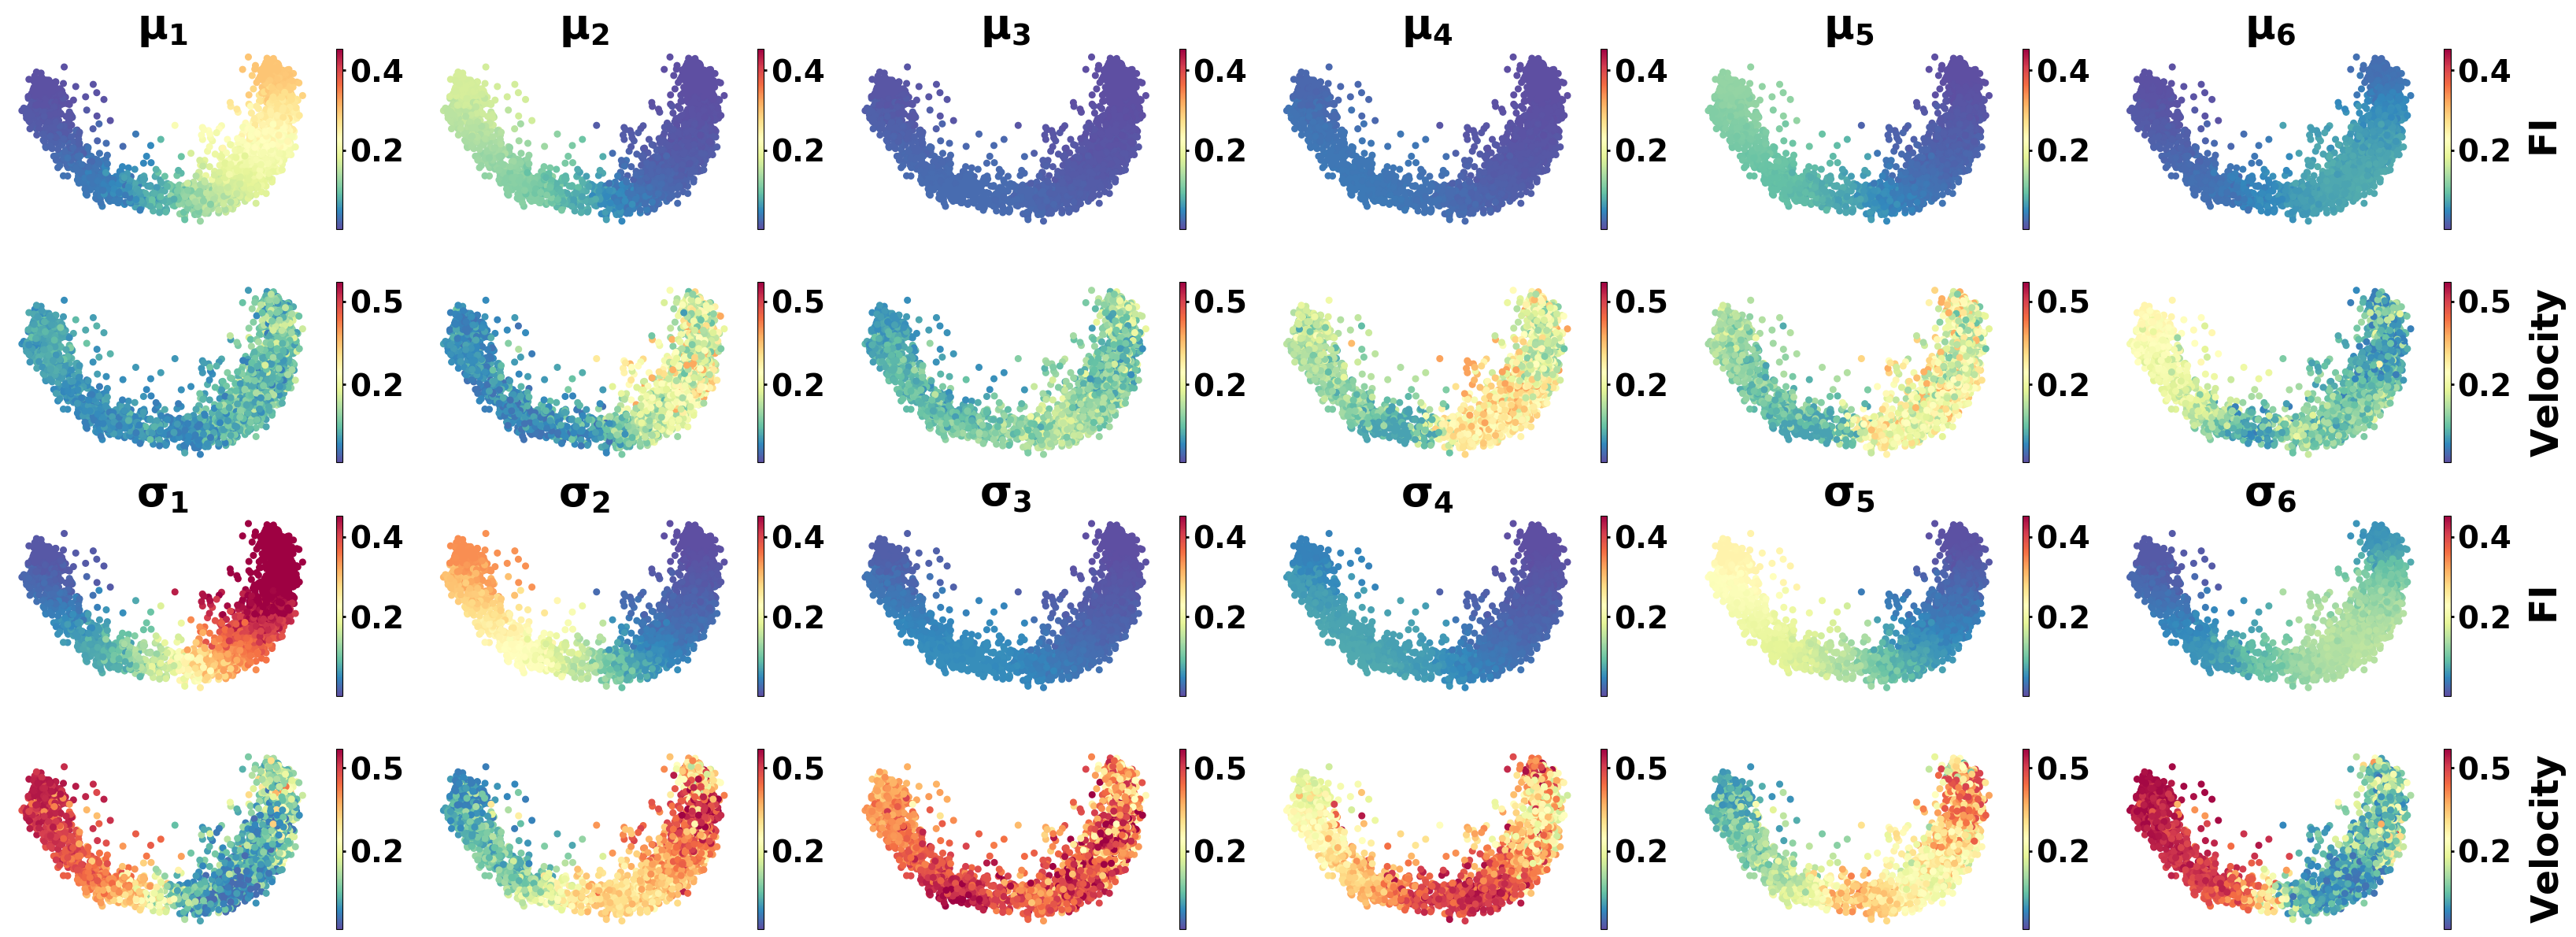

In [ ]:
data_name = "DG_bin_ppt"

[pca_dim, k_rc, d_pca, nrc] = [50, 30, 2, 10]
[k_nei, K, L] = [10, 2, 6]

clusters_name = "ClusterName"
root_cluster = "RadialGlia"
loc_path_graph = 'upper left'
basis = "pca"

t_list = np.array(['RadialGlia','nIPC', 'Nbl1', 'Nbl2', 'ImmGranule1', 'ImmGranule2', 'Granule' ])
branch_name = t_list[-1]

adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata = adata0.copy()
scv.pp.pca(adata, n_comps=pca_dim)
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=pca_dim, n_neighbors=k_nei)
scv.tl.velocity(adata)
print(adata)

for nrc in [10]:
    # average_path = np.load(path_path + f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}_dpca_{d_pca}.npy') 
    average_path = np.load(path_path + f'{data_name}_P2M_rc_nrc_{nrc}_dpca_{d_pca}.npy') 
    cell_arr, nearest_cell = find_nearest_indices_voronoi(adata = adata, path0= average_path, rc_distance= "X_pca", n_nei=k_rc, dim_n=d_pca)            
    average_path[:,0] = -average_path[:,0]


    # fig = sc.pl.embedding(
    #     adata,
    #     # color=[clusters_name, "paga"],
    #     color=[clusters_name],
    #     basis="pca",
    #     color_map=cmap,
    #     return_fig=True
    # )

    X_pca = adata.obsm['X_pca']
    row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
    col = adata.uns['neighbors']['indices'].flatten()
    w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
    adj_val = np.ones(col.shape)
    A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    A = A_mat
    W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    dc=np.mean(w_val)
    cell_nei=adata.uns['neighbors']['indices']
    nei_w=[]
    rho_arr=[]
    for ni in adata.uns['neighbors']['indices']:
        dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
        rho=np.sum(np.exp(-dij**2/dc**2))
        nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
        rho_arr.append(rho)
        
    rho_arr=np.array(rho_arr)/np.amax(rho_arr)
    nei_w=np.array(nei_w)
    nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

    def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
        X_s=X_val.copy()
        for ci in range(len(X_val)):
            X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
        return X_s

    if basis == "umap":
        X_umap = adata.obsm['X_umap']
        X_plt = X_umap[:,0]
        Y_plt = X_umap[:,1]
        X_min = np.min(X_plt)
        X_max = np.max(X_plt)
        Y_min = np.min(Y_plt)
        Y_max = np.max(Y_plt)
        X_len = (X_max-X_min)/5
        Y_len = (Y_max-Y_min)/5
        wid = min(X_len,Y_len)/30
        X_ori = X_min-wid*10
        Y_ori = Y_min-wid*10
    elif basis == "pca":
        X_umap = adata.obsm['X_pca'][:, :2]
        X_plt = X_umap[:,0]
        Y_plt = X_umap[:,1]
        X_min = np.min(X_plt)
        X_max = np.max(X_plt)
        Y_min = np.min(Y_plt)
        Y_max = np.max(Y_plt)
        X_len = (X_max-X_min)/5
        Y_len = (Y_max-Y_min)/5
        wid = min(X_len,Y_len)/30
        X_ori = X_min-wid*10
        Y_ori = Y_min-wid*10

    X = torch.tensor(adata.layers['Ms'], dtype=torch.float32) 
    Encoder_path = "encoder/"
    # for pca in [X_pca, eigengene, hotspot]:

    velo_g, velo_pca = get_velocity(adata,pca_dim,k_nei)
    model_path = Encoder_path + data_name+' '+str([k_nei,K,L])+'/'
    # eigengene = np.load(f"{model_path}cell_eigen_X.npy")
    # hotspot = np.load(f"{model_path}cell_hs_X.npy")
    model_name = f"{model_path}encoder.pt"
    model = torch.load(f'{model_name}')

    # PART 1------算FI_mu/sigma
    mu, sigma = model(torch.tensor(X))
    mu_learned = mu.detach().numpy()
    sigma_learned = sigma.detach().numpy()
    Fisher_g=np.zeros((X.shape[0],L*2,L*2))
    for i in range(X.shape[0]):
        for j in range(L):
            Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
            Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2
    Fisher_g_diag = np.zeros([X.shape[0],L*2])
    for i in range(X.shape[0]):
        Fisher_g_diag[i] = np.diag(Fisher_g[i])

    # PART 2------算dtheta_dt
    p_theta_p_gene = np.zeros([X.shape[0], L*2, X.shape[1]])
    for i in range(X.shape[0]):
        x0=torch.tensor(X[i,:],requires_grad=True)
        z_mu, z_sigma = model(x0)
        outputs = torch.cat([z_mu, z_sigma])
        grads = []
        for out in outputs:
            grad, = torch.autograd.grad(out, x0, retain_graph=True)
            grads.append(grad.detach().numpy())
        p_theta_p_gene[i, :, :] = np.stack(grads)
    dtheta_dt = np.einsum('ijk,ik->ij', p_theta_p_gene, velo_g)
    print("dtheta_dt.shape", dtheta_dt.shape)

    # 用.autograd()”的方式计算RC path上各点的 1.|v| [v_ms_autograd_average] 和 2.(gij) [FI_m_s_average].  
    # 画出的是对应的 gij vs |v|图

    # PART 3------ 把fisher inforamtion velocity归一化后作为权重
    # Fisher_g_diag = (Fisher_g_diag / Fisher_g_diag.max(axis=1, keepdims=True))
    Fisher_g_diag = (Fisher_g_diag / Fisher_g_diag.sum(axis=1, keepdims=True))
    print(Fisher_g_diag.shape)
    FI_m_s_average = np.zeros([len(cell_arr), 2*L])
    for i in range(len(cell_arr)):
        FI_m_s_path = Fisher_g_diag[cell_arr[i]]
        FI_m_s_average[i] = np.mean(FI_m_s_path, axis=0)
        if i == 0 :
            print(FI_m_s_path.shape)
    # sorted_indices = sort_FI(FI_m_s_average[:,L:])

    sorted_indices = [0,4,3,1,2,5,6,10,9,7,8,11]
    # sorted_indices = [0,4,3,1,2,5] # NOTE：这里为了画图好看，只选了三个参数。后面化supplement的图需要改。
    # sorted_indices = sort_FI(FI_m_s_average)
    # print("sorted_indices:", sorted_indices)
    # PART 4------ 把fisher inforamtion velocity归一化后作为权重
    # dtheta_dt = (np.abs(dtheta_dt) / np.abs(dtheta_dt).max(axis=1, keepdims=True))
    eps = 1e-8
    dtheta_dt = np.abs(dtheta_dt) / ( np.linalg.norm(dtheta_dt, axis=1, keepdims=True) + eps )
    print(dtheta_dt.shape)
    v_ms_autograd_average = np.zeros([len(cell_arr), 2*L])
    for i in range(len(cell_arr)):
        v_ms_path = np.abs(dtheta_dt)[cell_arr[i]] 
        v_ms_autograd_average[i] = np.mean(v_ms_path, axis=0)
        if i == 0 :
            print(v_ms_path.shape)


    # PART 5------show一下RC path
    # rc_path(adata, mu_learned, sigma_learned, average_path, basis, k_nei, data_name)
    cell_arr_plot(average_path, cell_arr, X_umap)
    rc_path_celltype(adata, average_path, basis, data_name, save = save, figure_path = figure_path, branch_name  = branch_name)

    # PART 6------比较一下velo_g和velo_pca
    v_gene_v_pca_rc(velo_g, velo_pca, cell_arr)

    # PART 7------画这部分的图
    print("现在是直接用.autograd()求导的：")
    rc_scatter(FI_m_s_average[:,sorted_indices], v_ms_autograd_average[:,sorted_indices], newMLP = False,
            save=save, figure_path=figure_path, branch_name = branch_name, mu=True)

    FI_umap_double_grid(X_umap, adata, i, 
                        ( Fisher_g_diag[:,sorted_indices])**2, ( dtheta_dt[:,sorted_indices])**2, t_list,
                        cluster_key=clusters_name, k_nei = k_nei, data_name = data_name,
                        newMLP=False,
                        use_mask = True, save=save, figure_path=figure_path, branch_name = branch_name, mu = True)
    # rc_scatter(FI_m_s_average[:,L:][:, sorted_indices], v_ms_autograd_average[:,L:][:, sorted_indices], newMLP = False,
    #         save=save, figure_path=figure_path, branch_name = branch_name)

    # FI_umap_double_grid(X_umap, adata, i, 
    #                     ( Fisher_g_diag[:,L:][:, sorted_indices] )**2, ( dtheta_dt[:,L:][:, sorted_indices] )**2, t_list,
    #                     cluster_key=clusters_name, k_nei = k_nei, data_name = data_name,
    #                     newMLP=False,
    #                     use_mask = True, save=save, figure_path=figure_path, branch_name = branch_name)

In [5]:
# 幂法
# print(top_k_eigenpairs(FI_pca, k=7))
# print("U_FI_Eg", U_FI_Eg)
# print("S_FI_Eg", S_FI_Eg)

# # PART 3------show一下RC path
# rc_num = average_path.shape[0]
# cells_visual = adata.obsm[f'X_pca'][:, :2]
# # 只取3种颜色，然后循环使用
# base_colors = ['orange', 'green', 'purple']
# plt.figure(figsize=(8,6))
# plt.scatter(cells_visual[:,0], cells_visual[:,1], s=5, color='lightgrey', label='All cells')
# plt.scatter(cells_visual[nearest_cell,0], cells_visual[nearest_cell,1], s=40, c='blue', label='Path points')

# for rc_i in range(rc_num):
#     color = base_colors[rc_i % 3]  # 每3种颜色循环
#     plt.scatter(cells_visual[nearest_cell[rc_i],0], cells_visual[nearest_cell[rc_i],1], s=100, c='red', marker='x')
#     plt.scatter(cells_visual[cell_arr[rc_i],0], 
#                 cells_visual[cell_arr[rc_i],1],
#                 s=25, c=[color], alpha=0.7, label=f'RC {rc_i}')

# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# plt.title('Nearest 30 cells for all RCs (3-color cycle)')
# plt.tight_layout()
# plt.show() 

# # PART 3------show一下RC path
# rc_num = average_path.shape[0]
# cells_visual = adata.obsm[f'X_{basis}'][:, :2]
# # 只取3种颜色，然后循环使用
# base_colors = ['orange', 'green', 'purple']
# plt.figure(figsize=(8,6))
# plt.scatter(cells_visual[:,0], cells_visual[:,1], s=5, color='lightgrey', label='All cells')
# plt.scatter(cells_visual[nearest_cell,0], cells_visual[nearest_cell,1], s=40, c='blue', label='Path points')

# for rc_i in range(rc_num):
#     color = base_colors[rc_i % 3]  # 每3种颜色循环
#     plt.scatter(cells_visual[nearest_cell[rc_i],0], cells_visual[nearest_cell[rc_i],1], s=100, c='red', marker='x')
#     plt.scatter(cells_visual[cell_arr[rc_i],0], 
#                 cells_visual[cell_arr[rc_i],1],
#                 s=25, c=[color], alpha=0.7, label=f'RC {rc_i}')

# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# plt.title('Nearest 30 cells for all RCs (3-color cycle)')
# plt.tight_layout()
# plt.show()


# pca_svd_rc_variance_all = compute_variances(U_FI_Eg, pca, cell_arr, k_rc= k_rc, L = L)
# pca_svd_rc_variance_average = np.array([np.mean(arr, axis=0) for arr in pca_svd_rc_variance_all])
# plot_all_variances(pca_svd_rc_variance_all)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True)

# pca_svd_rc_variance_all = compute_variances(U_FI_Eg, pca, cell_arr, k_rc= k_rc, L = L)
# pca_svd_rc_variance_average = np.array([np.mean(arr, axis=0) for arr in pca_svd_rc_variance_all])
# plot_all_variances(pca_svd_rc_variance_all)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True, simple= True)

# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = False)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = False, simple= True)
# eigengene_value_sum(S_FI_Eg, pca, L, cell_arr)
# eigengene_value(np.array(pca_svd_rc_variance_all), X_pca, L, cell_arr)

# FI_VAR_double_grid(S_FI_Eg, pca_svd_rc_variance_all, pca, L, cell_arr, norm=True)